In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import seaborn as sns
from pathlib import Path
import os
from os.path import join
import re
import math
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import RandomForestClassifier
# from sklearn.cluster import DBSCAN
from pyod.models.abod import ABOD
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.rod import ROD

from sklearn.utils import check_random_state
from sklearn.model_selection import ParameterSampler

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

import shap
import pickle
from joblib import Parallel, delayed
import geopandas as gpd

In [3]:
import warnings
from sklearn.ensemble import IsolationForest

warnings.filterwarnings("ignore", message="X has feature names, but IsolationForest was fitted without feature names")

# Coleta de Dados

In [4]:
MODULE_PATH = Path().absolute().parent
DATA_PATH = join(MODULE_PATH, "sources/processed")

In [5]:
complete_data = pd.read_csv(join(DATA_PATH, "complete_data_ground_truth.csv"))

In [6]:
complete_data

,ano,mes,data,precipitacao_total_soma,temperatura_bulbo_hora_media,temperatura_orvalho_hora_media,umidade_rel_hora_media,categoria_El Ninõ,categoria_La Ninã,categoria_Neutro,precipitacao_total_soma_outlier,temperatura_bulbo_hora_media_outlier,temperatura_orvalho_hora_media_outlier,umidade_rel_hora_media_outlier,total_outliers
0,2009,1,2009-01-01,3.417582,25.206729,20.251157,75.693584,0,1,0,0,0,0,0,0
1,2009,1,2009-01-02,6.923077,24.742439,20.038973,77.399546,0,1,0,0,0,0,0,0
2,2009,1,2009-01-03,10.432967,23.953602,19.699686,79.153908,0,1,0,1,0,0,0,1
3,2009,1,2009-01-04,5.701099,23.295086,18.676527,77.480558,0,1,0,0,0,0,0,0
4,2009,1,2009-01-05,5.127473,23.009149,17.906149,75.824475,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5839,2024,12,2024-12-27,5.853061,24.739027,19.652470,75.742225,0,1,0,0,0,0,0,0
5840,2024,12,2024-12-28,3.273469,25.208879,19.895573,74.673927,0,1,0,0,0,0,0,0
5841,2024,12,2024-12-29,5.895918,24.976626,19.863624,75.193482,0,1,0,0,0,0,0,0
5842,2024,12,2024-12-30,3.124490,25.026208,19.804128,74.833682,0,1,0,0,0,0,0,0


In [7]:
complete_data["data"] = pd.to_datetime(complete_data["data"])

In [8]:
complete_data = complete_data[complete_data.columns[:10].to_list() + ["total_outliers"]]

In [9]:
complete_data.head()

,ano,mes,data,precipitacao_total_soma,temperatura_bulbo_hora_media,temperatura_orvalho_hora_media,umidade_rel_hora_media,categoria_El Ninõ,categoria_La Ninã,categoria_Neutro,total_outliers
0,2009,1,2009-01-01,3.417582,25.206729,20.251157,75.693584,0,1,0,0
1,2009,1,2009-01-02,6.923077,24.742439,20.038973,77.399546,0,1,0,0
2,2009,1,2009-01-03,10.432967,23.953602,19.699686,79.153908,0,1,0,1
3,2009,1,2009-01-04,5.701099,23.295086,18.676527,77.480558,0,1,0,0
4,2009,1,2009-01-05,5.127473,23.009149,17.906149,75.824475,0,1,0,0


In [10]:
stations_data = pd.read_csv(join(DATA_PATH, "complete_df.csv"))

C:\Users\testd\AppData\Local\Temp\ipykernel_18512\2363858144.py:1: DtypeWarning: Columns (23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  stations_data = pd.read_csv(join(DATA_PATH, "complete_df.csv"))


# Pré-Processamento

## Definição do Pipeline

In [12]:
feature_cols = complete_data.columns.tolist()[3:10]
numerical_cols = feature_cols[:-3]
categorical_cols = feature_cols[-3:]

In [13]:
def split_data(
    df: pd.DataFrame,
    year_cap: int = 2024,
    train_size: float = None):

    df = df.copy()

    if train_size is not None:
        df_train = df.iloc[:int(len(df)* 0.7)]
        df_test = df.iloc[int(len(df)* 0.7):]
        return df_train, df_test
    
    df_train = df[df["ano"] < year_cap]
    df_test = df[df["ano"] == year_cap]
    
    return df_train, df_test

In [14]:
def scale_data(
    df: pd.DataFrame, 
    columns: list[str]):

    df = df.copy()  
    
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])
        
    return df

In [15]:
def create_residual_df(
    df: pd.DataFrame,
    numerical_cols: list[str],
    seasonal_period: int = 7):

    residual_df = df.copy()

    for col in numerical_cols:
        feature_decomposition = STL(residual_df[col], period=seasonal_period).fit()
        residual_df[col] = residual_df[col] - feature_decomposition.seasonal.values

    return residual_df

In [16]:
def create_ground_truth(
    df: pd.DataFrame,
    numerical_cols: list[str]):

    scaled_df = scale_data(df=df[numerical_cols], columns=numerical_cols)
    for col in scaled_df.columns:
        scaled_df[f'{col}_outlier'] = ((scaled_df[col] > 2) | (scaled_df[col] < -2))
        scaled_df[f'{col}_outlier'] = scaled_df[f'{col}_outlier'].astype(int)
    
    scaled_df["total_outliers"] = ((scaled_df > 2) | (scaled_df < -2)).sum(axis=1)

    ground_truth_cols = [col for col in scaled_df.columns.tolist() if col.endswith('_outlier') or col == 'total_outliers']
    ground_truth_data = scaled_df[ground_truth_cols]

    df[ground_truth_cols] = ground_truth_data

    return df

In [17]:
def preprocess_pipeline(
    df: pd.DataFrame,
    numerical_cols: list[str],
    normalize_data: bool = False,
    remove_seasonality: bool = False,
    seasonal_period: int = 7,
    year_cap: int = 2024,
    train_size: float = None,
    add_ground_truth: bool = False):

    df = df.copy()

    df_train, df_test = split_data(
        df=df, 
        year_cap=year_cap,
        train_size=train_size)
    if add_ground_truth:
        df_train = create_ground_truth(df=df_train, numerical_cols=numerical_cols)
        df_test = create_ground_truth(df=df_test, numerical_cols=numerical_cols)

    if remove_seasonality:
        df_train = create_residual_df(
            df=df_train, 
            numerical_cols=numerical_cols,
            seasonal_period=seasonal_period)

        df_test = create_residual_df(
            df=df_test, 
            numerical_cols=numerical_cols,
            seasonal_period=seasonal_period)
        
    if normalize_data:
        df_train = scale_data(df=df_train, columns=numerical_cols)
        df_test = scale_data(df=df_test, columns=numerical_cols)
    
    return df_train, df_test

In [18]:
with open(f'{MODULE_PATH}/explorations/artifacts/fine_tuning_results.pkl', 'rb') as f:
    results_dict = pickle.load(f)

# Treinamento o Melhor Modelo

In [19]:
def fit_anomaly_detector(
    train_data: pd.DataFrame,
    model: object,
    params: dict = None):

    if params is not None:
        model = model(**params).fit(train_data)
    else:
        model = model().fit(train_data)

    if hasattr(model, "feature_importances_"):
        feature_importances = pd.DataFrame(
            model.feature_importances_,
            index=train_data.columns,
            columns=["importancia"]).sort_values("importancia", ascending=False)
    else:
        clf_model = RandomForestClassifier().fit(
            train_data, model.labels_)

        feature_importances = pd.DataFrame(
            clf_model.feature_importances_,
            index=train_data.columns,
            columns=["importancia"]).sort_values("importancia", ascending=False)
    
    return model, feature_importances

In [20]:
best_model_params = results_dict["IForest"]

df_train, df_test = preprocess_pipeline(
    df=complete_data,
    numerical_cols=numerical_cols,
    normalize_data=best_model_params["normalize_data"],
    remove_seasonality=best_model_params["remove_seasonality"],
    seasonal_period=7,
    year_cap=2024,
    add_ground_truth=False
)

iforest_model, iforest_feature_importances = fit_anomaly_detector(
    train_data=df_train[feature_cols],
    model=IForest,
    params=best_model_params["params"]
)

# Avaliação de Resultados

In [21]:
def anomaly_detection_report(
    y_true: pd.Series,
    y_pred: pd.Series):

    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_pred)
    
    return pd.DataFrame(
        {
            "accuracy": [accuracy],
            "precision": [precision],
            "recall": [recall],
            "f1": [f1],
            "roc_auc": [roc_auc]
        }
    )

In [22]:
def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    model_report = anomaly_detection_report(
        y_true=y_true,
        y_pred=y_pred)

    return f1_score(y_true, y_pred), model_report

In [23]:
train_labels = np.where(df_train["total_outliers"] > 0, 1, 0)
test_labels = np.where(df_test["total_outliers"] > 0, 1, 0)

train_pred = iforest_model.labels_

test_pred = iforest_model.predict(df_test[feature_cols])
test_anomaly_scores = iforest_model.decision_function(df_test[feature_cols])

train_report = anomaly_detection_report(
    y_true=train_labels,
    y_pred=train_pred)
        
test_report = anomaly_detection_report(
    y_true=test_labels,
    y_pred=test_pred)

df_train["anomaly"] = train_pred
df_train["anomaly_score"] = iforest_model.decision_function(df_train[feature_cols])
        

df_test["anomaly"] = test_pred
df_test["anomaly_score"] = test_anomaly_scores

In [24]:
train_report

,accuracy,precision,recall,f1,roc_auc
0,0.814531,0.677616,0.425841,0.523005,0.681146


In [25]:
test_report

,accuracy,precision,recall,f1,roc_auc
0,0.806011,0.887218,0.678161,0.76873,0.800018


In [26]:
complete_predictions = pd.concat([df_train, df_test])

In [40]:
stations_dict = {}
for group_id, df_values in stations_data.groupby("id_estacao"):

    try:

        iforest_station, feature_importances_station = fit_anomaly_detector(
            train_data=df_values[feature_cols].ffill().bfill().dropna(),
            model=IForest,
            params=best_model_params["params"]
        )

        train_pred = iforest_station.labels_

        df_values["anomaly"] = train_pred
        df_values["anomaly_score"] = iforest_model.decision_function(df_values[feature_cols].ffill().bfill().dropna())

        stations_dict[group_id] = df_values
    
    except Exception as e:
        print(f"Exception {e} on {group_id}")
        pass

Exception Found array with 0 sample(s) (shape=(0, 7)) while a minimum of 1 is required. on A312


# Detecção de Anomalias nas Estações

In [46]:
stations_complete_predictions = pd.concat(list(stations_dict.values()))

In [55]:
stations_anomaly_perc = stations_complete_predictions.groupby(by=["id_estacao"])["anomaly"].value_counts(normalize=True).reset_index()
stations_anomaly_perc = stations_anomaly_perc.loc[stations_anomaly_perc["anomaly"] == 1].reset_index(drop=True)

In [58]:
stations_anomaly_perc.sort_values("proportion", ascending=False)

,id_estacao,anomaly,proportion
73,A712,1,0.161290
36,A313,1,0.161290
58,A516,1,0.161290
76,A723,1,0.161290
60,A520,1,0.161290
...,...,...,...
14,A119,1,0.148015
28,A304,1,0.146817
101,A905,1,0.144251
17,A202,1,0.140486


In [59]:
url_municipios_ibge = "https://raw.githubusercontent.com/kelvins/Municipios-Brasileiros/main/csv/municipios.csv"
url_estados_ibge = "https://raw.githubusercontent.com/kelvins/municipios-brasileiros/refs/heads/main/csv/estados.csv"

In [62]:
stations_info = pd.read_csv(join(MODULE_PATH, "sources/raw/basedosdados/br_inmet_bdmep_estacao.csv"), dtype={"id_municipio": str})
df_municipios = pd.read_csv(url_municipios_ibge, usecols=["codigo_ibge", "codigo_uf"], dtype={"codigo_ibge": str})
df_estados = pd.read_csv(url_estados_ibge, usecols=["codigo_uf", "uf", "regiao"],  dtype={"codigo_ibge": str})

In [63]:
df_municipios.rename(columns={"codigo_ibge": "id_municipio"}, inplace=True)
stations_info = stations_info.merge(df_municipios, on="id_municipio", how="left").merge(df_estados, on="codigo_uf", how="left")
stations_info["data_fundacao"] = pd.to_datetime(stations_info["data_fundacao"], errors="coerce")

In [70]:
merged_stations = stations_complete_predictions.merge(stations_info, how="left", on="id_estacao")

In [71]:
merged_stations.to_csv("merged_stations.csv", index=False)

In [93]:
brazil_map = gpd.read_file(f"{MODULE_PATH}/misc/BR_UF_2022.shp")

In [94]:
anomalies_by_state = merged_stations.groupby('uf')["anomaly"].sum().reset_index()
anomalies_scores_by_state = merged_stations.groupby('uf')["anomaly_score"].mean().reset_index()
brazil_map = brazil_map.merge(anomalies_by_state.rename(columns={"uf": "SIGLA_UF"}), how="left", on="SIGLA_UF")
brazil_map = brazil_map.merge(anomalies_scores_by_state.rename(columns={"uf": "SIGLA_UF"}), how="left", on="SIGLA_UF")
brazil_map["anomaly"] = brazil_map["anomaly"].fillna(0)
brazil_map["anomaly_score"] = brazil_map["anomaly_score"].fillna(0)

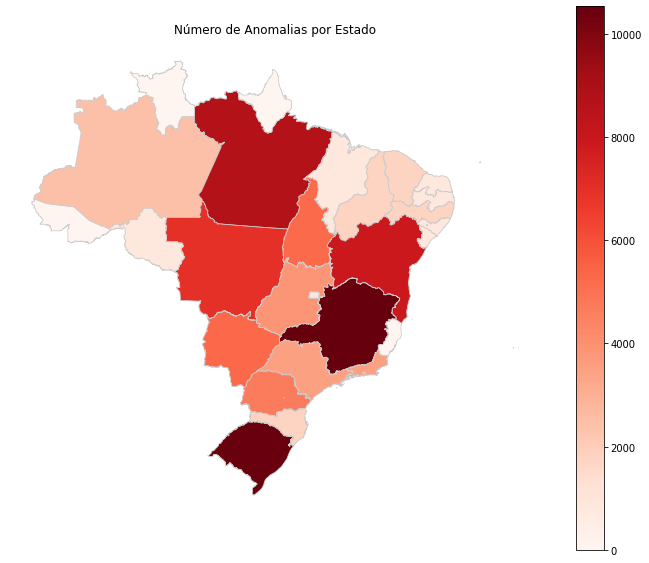

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
brazil_map.plot(column='anomaly', cmap='Reds', linewidth=0.8, edgecolor='0.8', ax=ax, legend=True)
# brazil_map.plot(ax=ax, color="darkgrey")

plt.title("Número de Anomalias por Estado")
plt.axis('off')
plt.show()

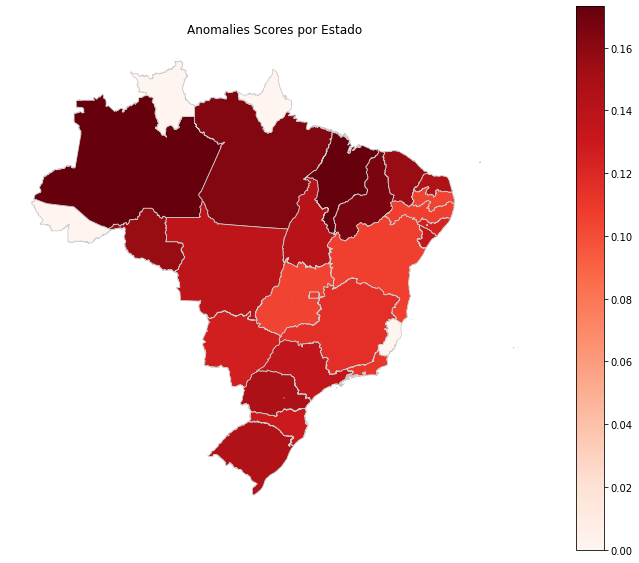

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
brazil_map.plot(column='anomaly_score', cmap='Reds', linewidth=0.8, edgecolor='0.8', ax=ax, legend=True)
# brazil_map.plot(ax=ax, color="darkgrey")

plt.title("Anomalies Scores por Estado")
plt.axis('off')
plt.show()